
# AllocationTask — Basics

This notebook gives a compact, **teaching-style** walkthrough of the `AllocationTask`:
- define simple generators (value streams),
- define a simple agent that returns allocation weights,
- run the task and inspect logs,
- plot the budget (wealth) trajectory.

> Domain-agnostic: generators emit numeric values over time; the agent chooses a long-only allocation vector (non-negative, sums to 1). Returns are computed from relative changes; optional turnover cost penalizes rebalancing.


In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Import from your package (ensure tsdm is installed or on PYTHONPATH)
from tsdm.tasks import AllocationTask



## 1) Tiny demo components

We define two lightweight generators and a couple of simple agents:

- `UpGen`: value increases by +1 each step.
- `DownGen`: value decreases by -1 each step.
- `EqualWeightAgent`: always returns equal allocations.
- `FirstOnlyAgent`: allocates 100% to the first generator.


In [2]:

class UpGen:
    """Monotone increasing generator: v_t = v_{t-1} + 1"""
    def generate_value(self, last):
        return (0.0 if last is None else last) + 1.0

class DownGen:
    """Monotone decreasing generator: v_t = v_{t-1} - 1"""
    def generate_value(self, last):
        return (0.0 if last is None else last) - 1.0

class EqualWeightAgent:
    """Always returns equal weights across K streams."""
    def __init__(self, k):
        self.k = int(k)
    def observe(self, values):
        # values is a vector of current stream values
        pass
    def place_bet(self):
        return np.full(self.k, 1.0 / self.k, dtype=float)

class FirstOnlyAgent:
    """Allocates 100% to the first stream."""
    def __init__(self, k):
        self.k = int(k)
    def observe(self, values):
        pass
    def place_bet(self):
        w = np.zeros(self.k, dtype=float)
        w[0] = 1.0
        return w



## 2) Run: Two rising streams + EqualWeightAgent

Since both streams increase by +1 each step, any long-only allocation should grow the budget (with zero turnover cost).


In [3]:

gens = [UpGen(), UpGen()]
agent = EqualWeightAgent(k=2)

task = AllocationTask(
    generators=gens,
    agent=agent,
    total_movements=10,
    start_values=np.array([10.0, 10.0], dtype=float),
    initial_budget=1.0,
    tc=0.0,  # turnover cost
)
final_budget = task.play_game()

print(f"Final budget: {final_budget:.6f}")
print(f"Number of log entries: {len(task.log)}")
print("First 3 logs:")
for rec in task.log[:3]:
    print({k: rec[k] for k in ["t", "values", "relative_changes", "allocations", "combined_change", "new_budget"]})


Final budget: 2.000000
Number of log entries: 10
First 3 logs:
{'t': 1, 'values': array([11., 11.]), 'relative_changes': array([0.1, 0.1]), 'allocations': array([0.5, 0.5]), 'combined_change': 0.10000000000000009, 'new_budget': 1.1}
{'t': 2, 'values': array([12., 12.]), 'relative_changes': array([0.09090909, 0.09090909]), 'allocations': array([0.5, 0.5]), 'combined_change': 0.09090909090909083, 'new_budget': 1.2}
{'t': 3, 'values': array([13., 13.]), 'relative_changes': array([0.08333333, 0.08333333]), 'allocations': array([0.5, 0.5]), 'combined_change': 0.08333333333333326, 'new_budget': 1.2999999999999998}



### Plot budget trajectory


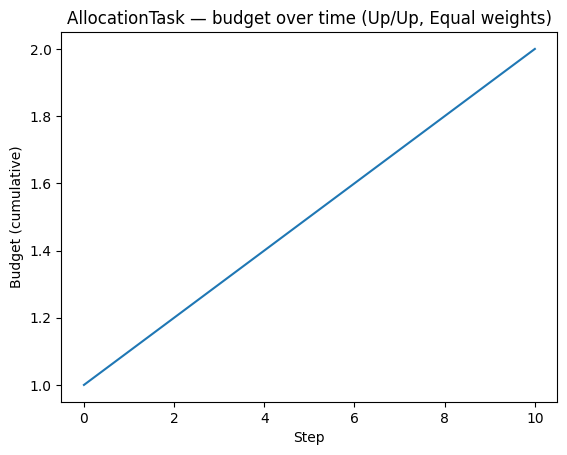

In [4]:

plt.figure()
plt.plot(task.budget_development)
plt.xlabel("Step")
plt.ylabel("Budget (cumulative)")
plt.title("AllocationTask — budget over time (Up/Up, Equal weights)")
plt.show()



## 3) Run: Mixed regime (Up / Down) + FirstOnlyAgent

Here we make one stream rise and the other fall. Allocating entirely to the rising stream should produce a higher budget than equal weighting.


In [9]:

gens_mixed = [UpGen(), DownGen()]
agent_first = FirstOnlyAgent(k=2)
agent_equal = EqualWeightAgent(k=2)

task_first = AllocationTask(
    generators=gens_mixed,
    agent=agent_first,
    total_movements=10,
    start_values=np.array([10.0, 10.0], dtype=float),
    initial_budget=1.0,
    tc=0.0,
)
budget_first = task_first.play_game()

task_equal = AllocationTask(
    generators=gens_mixed,
    agent=agent_equal,
    total_movements=10,
    start_values=np.array([10.0, 10.0], dtype=float),
    initial_budget=1.0,
    tc=0.0,
)
budget_equal = task_equal.play_game()

print(f"Final budget (FirstOnlyAgent): {budget_first:.6f}")
print(f"Final budget (EqualWeightAgent): {budget_equal:.6f}")
for i, log_entry in enumerate(task_equal.log):
    print(f"Step {i}: {log_entry}")

Final budget (FirstOnlyAgent): 2.000000
Final budget (EqualWeightAgent): 0.266667
Step 0: {'t': 1, 'values': array([11.,  9.]), 'relative_changes': array([ 0.1, -0.1]), 'allocations': array([0.5, 0.5]), 'turnover': 0.0, 'combined_change': 5.551115123125783e-17, 'new_budget': 1.0}
Step 1: {'t': 2, 'values': array([12.,  8.]), 'relative_changes': array([ 0.09090909, -0.11111111]), 'allocations': array([0.5, 0.5]), 'turnover': 0.0, 'combined_change': -0.010101010101010166, 'new_budget': 0.9898989898989898}
Step 2: {'t': 3, 'values': array([13.,  7.]), 'relative_changes': array([ 0.08333333, -0.125     ]), 'allocations': array([0.5, 0.5]), 'turnover': 0.0, 'combined_change': -0.02083333333333337, 'new_budget': 0.9692760942760942}
Step 3: {'t': 4, 'values': array([14.,  6.]), 'relative_changes': array([ 0.07692308, -0.14285714]), 'allocations': array([0.5, 0.5]), 'turnover': 0.0, 'combined_change': -0.032967032967033016, 'new_budget': 0.9373219373219371}
Step 4: {'t': 5, 'values': array([15


## 4) Turnover cost illustration

We compare two runs with the same allocations but different `tc` (transaction/turnover cost). Higher `tc` should reduce the final budget if the agent changes allocations over time.


In [6]:

class ToggleAgent:
    """Alternates between [1, 0] and [0, 1] to induce maximum turnover."""
    def __init__(self): self.k = 0
    def observe(self, values): pass
    def place_bet(self):
        self.k += 1
        return np.array([1.0, 0.0]) if self.k % 2 else np.array([0.0, 1.0])

# Increasing streams to isolate turnover effects
gens2 = [UpGen(), UpGen()]
start_vals = np.array([10.0, 10.0], dtype=float)

# With turnover cost
task_hi_tc = AllocationTask(
    generators=gens2, agent=ToggleAgent(), total_movements=10,
    start_values=start_vals, initial_budget=1.0, tc=0.05,
)
b_hi = task_hi_tc.play_game()

# Without turnover cost
task_no_tc = AllocationTask(
    generators=gens2, agent=ToggleAgent(), total_movements=10,
    start_values=start_vals, initial_budget=1.0, tc=0.0,
)
b_no = task_no_tc.play_game()

print(f"Final budget (tc=0.05): {b_hi:.6f}")
print(f"Final budget (tc=0.00): {b_no:.6f}")


Final budget (tc=0.05): 0.788483
Final budget (tc=0.00): 2.000000



### Plot: budget trajectories (with vs. without turnover cost)


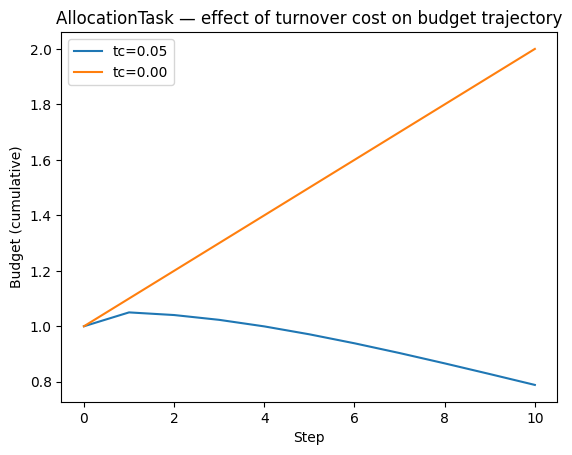

In [7]:

plt.figure()
plt.plot(task_hi_tc.budget_development, label="tc=0.05")  # labels OK; no custom colors
plt.plot(task_no_tc.budget_development, label="tc=0.00")
plt.xlabel("Step")
plt.ylabel("Budget (cumulative)")
plt.title("AllocationTask — effect of turnover cost on budget trajectory")
plt.legend()
plt.show()



## 5) Tips for extending

- Swap in your own **generators** implementing `.generate_value(last)`.
- Build smarter **agents** that adapt allocations based on observed `values` (e.g., trend, mean-reversion, learned policies).
- Use the `task.log` list of dictionaries for analysis; convert it to a DataFrame for inspection.
- Add `tc > 0` to penalize rebalancing.
